# HATPRO
The following example presents the nadir passive microwave radiometer HATPRO. The Humidity And Temperature PROfiler (HATPRO) replaced the MiRAC-P radiometer during the MOSAiC-ACA campaign.

If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

## Data access
* To analyse the data they first have to be loaded by importing the (AC)³airborne meta data catalogue. To do so the ac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue).

## Get data

In [1]:
import ac3airborne

In [2]:
cat = ac3airborne.get_intake_catalog()

datasets = []
for campaign in ['MOSAiC-ACA']:
    datasets.extend(list(cat[campaign]['P5']['HATPRO']))
datasets

['MOSAiC-ACA_P5_RF02',
 'MOSAiC-ACA_P5_RF04',
 'MOSAiC-ACA_P5_RF05',
 'MOSAiC-ACA_P5_RF06',
 'MOSAiC-ACA_P5_RF07',
 'MOSAiC-ACA_P5_RF08',
 'MOSAiC-ACA_P5_RF09',
 'MOSAiC-ACA_P5_RF10',
 'MOSAiC-ACA_P5_RF11']

```{note}
Have a look at the attributes of the xarray dataset `ds_hatpro` for all relevant information on the dataset, such as author, contact, or citation information.
```

In [3]:
ds_hatpro = cat['MOSAiC-ACA']['P5']['HATPRO']['MOSAiC-ACA_P5_RF11'].to_dask()
ds_hatpro

Invalid MIT-MAGIC-COOKIE-1 key

<xarray.Dataset>
Dimensions:    (channel: 14, time: 15553)
Coordinates:
  * time       (time) datetime64[ns] 2020-09-13T09:20:01 ... 2020-09-13T14:59:46
  * channel    (channel) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    frequency  (channel) float32 ...
    tb         (time, channel) float32 ...
Attributes:
    institution:  Institute of Geophysics and Meteorology (IGM), University o...
    source:       airborne observation
    author:       Nils Risse
    convention:   CF-1.8
    featureType:  trajectory
    mission:      MOSAiC-ACA
    platform:     Polar 5
    flight_id:    RF11
    title:        HATPRO brightness temperature
    history:      measured onboard Polar 5 during MOSAiC-ACA campaign; proces...
    contact:      n.risse@uni-koeln.de, mario.mech@uni-koeln.de
    created:      2021-07-19

The dataset includes brightness temperatures (`tb`) observed by HATPRO at the 22 GHz water vapor absorption line (22.24, 23.04, 23.84, 25.44, 26.24, 27.84 GHz), at the 31.3 GHz window frequency and the 56 GHz oxygen absorption line (51.26, 52.28, 53.86, 54.94, 56.66, 57.3, 58.0 GHz).

## Load Polar 5 flight phase information
Polar 5 flights are divided into segments to easily access start and end times of flight patterns. For more information have a look at the respective [github](https://github.com/igmk/flight-phase-separation) repository.

At first we want to load the flight segments of (AC)³airborne

In [4]:
meta = ac3airborne.get_flight_segments()

The following command lists all flight segments into the dictionary `segments`

In [5]:
segments = {s.get("segment_id"): {**s, "flight_id": flight["flight_id"]}
             for campaign in meta.values()
             for platform in campaign.values()
             for flight in platform.values()
             for s in flight["segments"]
            }

In this example we want to look at a high-level segment during MOSAiC-ACA RF11

In [6]:
seg = segments["MOSAiC-ACA_P5_RF11_hl05"]

Using the start and end times of the segment `MOSAiC-ACA_P5_RF11_hl05` stored in `seg`, we slice the HATPRO data to the selected flight section.

In [7]:
ds_hatpro_sel = ds_hatpro.sel(time=slice(seg["start"], seg["end"]))

In polar regions, the surface type is helpful for the interpretation of airborne passive microwave observations, especially near the marginal sea ice zone, as generally a higher emissivity is expected over sea ice compared to open ocean. Therefore, we also load AMSR2 sea ice concentration data along the Polar 5 flight track, which is operationally derived by the University of Bremen.

In [8]:
ds_sea_ice = cat['MOSAiC-ACA']['P5']['AMSR2_SIC']['MOSAiC-ACA_P5_RF11'].to_dask().sel(
    time=slice(seg["start"], seg["end"]))

## Plots

In [9]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import numpy as np
plt.style.use("../mplstyle/book")

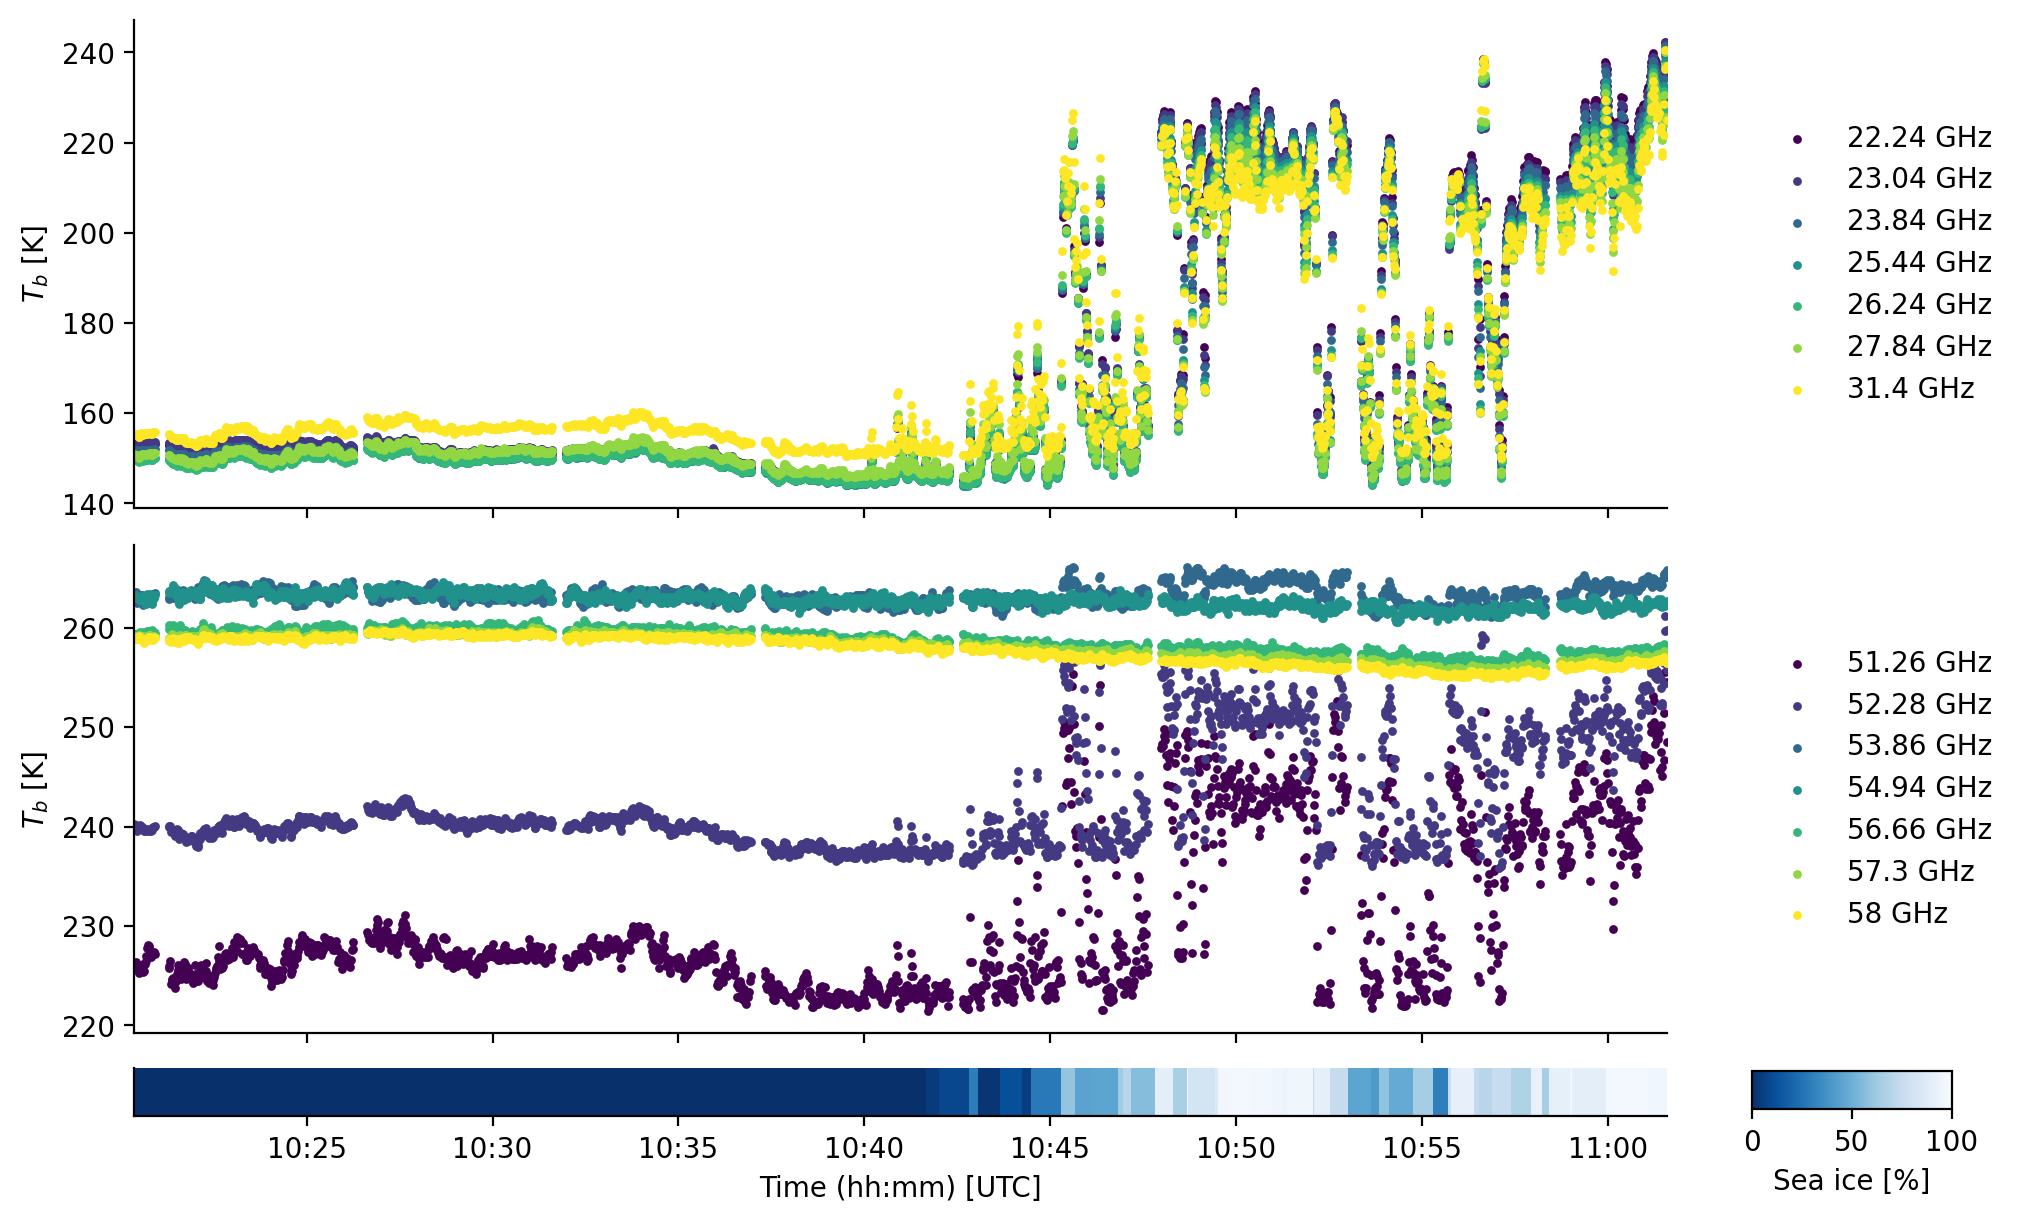

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 0.1)))

kwargs = dict(s=10, linewidths=0)
colors = cm.get_cmap('viridis', 7).colors
for i in range(0, 7):
    ax1.scatter(ds_hatpro_sel.time, ds_hatpro_sel.tb.sel(channel=i), label='%g GHz'%ds_hatpro_sel.frequency.sel(channel=i).item(), color=colors[i], **kwargs)

for i in range(7, 14):
    ax2.scatter(ds_hatpro_sel.time, ds_hatpro_sel.tb.sel(channel=i), label='%g GHz'%ds_hatpro_sel.frequency.sel(channel=i).item(), color=colors[i-7], **kwargs)

ax1.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax2.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')

ax1.set_ylabel('$T_b$ [K]')
ax2.set_ylabel('$T_b$ [K]')

# plot AMSR2 sea ice concentration
im = ax3.pcolormesh(np.array([ds_sea_ice.time, ds_sea_ice.time]),
               np.array([0, 1]),
               np.array([ds_sea_ice.sic]), cmap='Blues_r', vmin=0, vmax=100,
               shading='auto')
cax = fig.add_axes([0.87, 0.085, 0.1, ax3.get_position().height])
fig.colorbar(im, cax=cax, orientation='horizontal', label='Sea ice [%]')
ax3.tick_params(axis='y', labelleft=False, left=False)

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.set_xlabel('Time (hh:mm) [UTC]')

plt.show()